# Only use competicion data for both fine-tuning and final classification

Data used for fine-tuning and final classification :

* corpus completo 5 temas - 08-sep-2016 - codificacion 5 temas.csv (competition)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
from fastai.text import *
import html
import json

import pandas as pd
import numpy as np
from google_drive_downloader import GoogleDriveDownloader as gdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(52)

In [2]:
YEAR='2018'
DATA_PATH=Path('./DATA/'+YEAR)
# DATA_PATH=Path('./data/election_tweets')

WIKILM_PATH=Path('./WIKI_LM/es/models')
PRE_FINETUNE_PATH=Path('./FINETUNE/'+YEAR)

TWEETSLM_PATH=Path('./TWEETS_LM/'+YEAR)
CLAS_PATH=Path('./TWEETS_CLAS/'+YEAR)

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Utils

In [3]:
def flattern(A):
    'Source: https://stackoverflow.com/a/17867797/7273299'
    
    'Flattens a list of lists and strings into a list.'
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flattern(i))
        else: rt.append(i)
    return rt

def isInt(v):
    'Source: https://stackoverflow.com/a/9859202/7273299'
    
    'Checks if a string is a number.'
    try:     i = int(v)
    except:  return False
    return True

def char_count(word, chars, lbound=2):
    char_count = [word.count(char) for char in chars]
    return all(i >= lbound for i in char_count)

def replace_lol(repl_str, texts):
    for string, chars in repl_str:
        texts = [[[string] if char_count(i, set(chars), 2) else i for i in text.split()] for text in texts]
        texts = np.array([flattern(text) for text in texts])
        texts = np.array([' '.join(text) for text in texts])
    return texts

import unicodedata

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

def preprocess_tweets(tweets):
    """
    twitter specific text processing and shuffle
    """
    # Remove \n
    tweets = np.array([str(i).replace('\n','. ') for i in tweets])
    tweets = np.array([str(i).replace('&lt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('&gt;',' ') for i in tweets])
    tweets = np.array([str(i).replace('\xa0',' ') for i in tweets])
    
    # Remove accents
    tweets = np.array([strip_accents(i) for i in tweets])
    
    # Placeholders for hyperlinks and user references
    tweets = [['hyp_link' if i.startswith('http') 
               else 'hyp_link' if i.startswith('.http') 
               else 'user_ref' if i.startswith('@')
               else 'hash_tag' if i.startswith('#')
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for integers
    tweets = [[['int_string'] if isInt(i) 
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Prefix for slang
    tweets = [[['que'] if i in ['q', 'k', 'qu', 'ke', 'qe'] 
               else ['por'] if i=='x' 
               else ['porque'] if i in ['xq', 'pq', 'porq'] 
               else ['de'] if i=='d' 
               else ['te'] if i=='t'
               else ['también'] if i=='tb'
               else ['Que'] if i in ['Q', 'K', 'Qu','Ke', 'Qe'] 
               else ['Por'] if i=='X'
               else ['Porque'] if i in ['Xq', 'Pq', 'Porq'] 
               else ['De'] if i=='D' 
               else ['Te'] if i=='T'
               else ['También'] if i=='Tb'
               else i for i in tweet.split()] for tweet in tweets]
    tweets = np.array([flattern(tweet) for tweet in tweets])
    tweets = np.array([' '.join(i) for i in tweets])

    # Lol type characters
    repl_str = [('risa_ja','ja'), ('risa_ji','ji'), ('risa_je','je'), ('risa_jo','jo'), ('risa_ju', 'ju'),
               ('risa_ja','aj'), ('risa_ji','ij'), ('risa_ju', 'uj'), ('risa_ja', 'lol')]

    # Adding prefix to lol type characters
    tweets = replace_lol(repl_str, tweets)

    return tweets


In [4]:
#!python -m spacy download es
import spacy
spacy.prefer_gpu()

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang='es').proc_all_mp(partition_by_cores(texts), lang='es')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
#     print(df)
    for i, r in enumerate(df):
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

## Dataframe for Language Model

In [5]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_tweets = pd.read_csv(DATA_PATH/'tweets-es.csv', header=None, nrows=277394)

In [6]:
tweets = np.concatenate([df_tweets.values, df_trn.values, df_val.values, df_tst.values])
del df_trn, df_val, df_tst

tweets[:5]

array([['2019-06-05 23:48:18',
        '@July91434885 @JohnLo36732656 Ahora que dirá el zoquete de las vaquitas amarillas @SergioMayerb que se le cruzó?'],
       ['2019-06-05 23:48:18', '@lailamontero La palabra malos alberga muchos sentidos, cual de todos?'],
       ['2019-06-05 23:48:18',
        '@LeonKrauze Ya basta de amenazas de este sujeto! A unirnos los mexicanos y boicot a empresas americanas, cero compr… https://t.co/PEcE62jysr'],
       ['2019-06-05 23:48:18', 'RT @fracasadaDeJL: Lo que es el documental de Juan Luis estoy llorando'],
       ['2019-06-05 23:48:18',
        'mi último retuit:\n1: i love being mexican\n2: vivo en el estado en donde todo se permite cuando ya todos los demás e… https://t.co/SdkO994PXU']],
      dtype=object)

In [7]:
np.random.shuffle(tweets)
tweets[:5]

array([['2019-06-05 23:36:14',
        'RT @TauromaquiaTMX: El toro bravo es ecología en estado de gracia, un homenaje a la naturaleza por su forma de ser criado, por la conservac…'],
       ['2019-06-05 23:40:26', '@cristiano_kardo Lunático de  miliciano kkkkkkkm'],
       ['2019-06-05 23:47:53', '@SporTV Canpeaooooooo'],
       ['2019-06-05 23:37:27',
        'No es que sea fría, es que no le doy mi calor a cualquiera. Allí está la diferencia.'],
       ['2019-06-05 23:37:52',
        'RT @liderfiscal: "Naasón Joaquín García" La derecha descubriendo el hilo negro, se cuelgan de cualquier nota, asi los queria ver en el juic…']],
      dtype=object)

In [8]:
tweets[:,1] = preprocess_tweets(tweets[:,1])

In [9]:
tweets[:5]

array([['2019-06-05 23:36:14',
        'RT user_ref El toro bravo es ecologia en estado de gracia, un homenaje a la naturaleza por su forma de ser criado, por la conservac'],
       ['2019-06-05 23:40:26', 'user_ref Lunatico de miliciano kkkkkkkm'],
       ['2019-06-05 23:47:53', 'user_ref Canpeaooooooo'],
       ['2019-06-05 23:37:27',
        'No es que sea fria, es que no le doy mi calor a cualquiera. Alli esta la diferencia.'],
       ['2019-06-05 23:37:52',
        'RT user_ref "Naason Joaquin Garcia" La derecha descubriendo el hilo negro, se cuelgan de cualquier nota, asi los queria ver en el juic']],
      dtype=object)

In [10]:
tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm = train_test_split( tweets[:,1], tweets[:,0], test_size=0.10)

del tweets

In [11]:
col_names = ['label', 'tweet']

df_trn = pd.DataFrame({'tweet':tweets_train_lm, 'label':[0]*len(tweets_train_lm)}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid_lm, 'label':[0]*len(tweets_valid_lm)}, columns=col_names)

del tweets_train_lm, tweets_valid_lm, labels_train_lm, labels_valid_lm

In [12]:
df_trn.shape, df_val.shape

((252289, 2), (28033, 2))

In [13]:
df_trn.to_csv(TWEETSLM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(TWEETSLM_PATH/'validation.csv', header=False, index=False)

del df_trn, df_val

## Tokenize and Standarize General Tokens


In [14]:
chunksize=24000

re1 = re.compile(r'  +')

In [15]:
df_trn = pd.read_csv(TWEETSLM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(TWEETSLM_PATH/'validation.csv', header=None, chunksize=chunksize)

In [16]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [18]:
len(tok_trn),len(trn_labels), len(tok_val), len(val_labels)

(252289, 252289, 28033, 28033)

In [17]:
print(tok_trn[:2])

[['\n', 'xbos', 'user_ref', 't_up', 'jajajajajajaj', 'te', 't_up', 'amo', 't_up', 'dejen', 'de', 't_up', 'pelear'], ['\n', 'xbos', 'rt', 'user_ref', 't_up', 'cuando', 'me', 't_up', 'voy', 'a', 't_up', 'poder', 't_up', 'operar', 'la', 't_up', 'nariz', 'tk_rep', '4', '?', 'c', 'u', 'a', 'n', 'de', 'o']]


In [19]:
(TWEETSLM_PATH/'tmp').mkdir(exist_ok=True)

In [20]:
np.save(TWEETSLM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(TWEETSLM_PATH/'tmp'/'tok_val.npy', tok_val)

In [23]:
tok_trn = np.load(TWEETSLM_PATH/'tmp'/'tok_trn.npy', allow_pickle=True)
tok_val = np.load(TWEETSLM_PATH/'tmp'/'tok_val.npy', allow_pickle=True)

In [24]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(20)

[('\n', 252289),
 ('xbos', 252289),
 ('user_ref', 227915),
 ('de', 137228),
 ('.', 129595),
 ('que', 121996),
 ('rt', 118955),
 (',', 103940),
 ('la', 87893),
 ('a', 81144),
 ('hyp_link', 81092),
 ('t_up', 76375),
 ('el', 71009),
 ('y', 69315),
 ('en', 61547),
 ('no', 56757),
 ('me', 40794),
 ('es', 36523),
 ('hash_tag', 36511),
 ('se', 34195)]

In [25]:
max_vocab = 60000
min_freq = 1

In [26]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

52275

In [27]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [28]:
np.save(TWEETSLM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(TWEETSLM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'wb'))

## Load Encoder Weights for Language Model

In [7]:
BACKBONE_MODEL = PRE_FINETUNE_PATH/'models/lm1_wgts.h5'

In [8]:
wgts = torch.load(BACKBONE_MODEL, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [9]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [10]:
itos2 = pickle.load((PRE_FINETUNE_PATH/'tmp'/'itos.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [11]:
len(itos2)

60002

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [12]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy', allow_pickle=True)
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy', allow_pickle=True)
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))

In [13]:
vs=len(itos)
vs,len(trn_lm)

(52275, 252289)

In [14]:
em_sz,nh,nl = 400,1150,3

In [15]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
n_replaced_vocab = 0

for i,w in enumerate(itos):
    r = stoi2[w]
    if r>=0 :
        new_w[i] = enc_wgts[r]
        n_replaced_vocab +=1
    else:
        new_w[i] = row_m

print(f'Reuse {n_replaced_vocab} word embeddings from fine-tuning')
print(f'{vs-n_replaced_vocab} where not in vocab from fine-tuning')

Reuse 22795 word embeddings from fine-tuning
29480 where not in vocab from fine-tuning


"We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying."

In [16]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language Model Finetuning

In [17]:
# wd=1e-7
bptt=70
bs=32
em_sz,nh,nl = 400,1150,3
opt_fn = partial(optim.SGD, momentum=0.9)

In [18]:
trn_lm = np.load(TWEETSLM_PATH/'tmp'/'trn_ids.npy', allow_pickle=True)
val_lm = np.load(TWEETSLM_PATH/'tmp'/'val_ids.npy', allow_pickle=True)
trn_lm = np.concatenate(trn_lm)
val_lm = np.concatenate(val_lm)

In [19]:
trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
val_dl = LanguageModelLoader(val_lm, bs, bptt)

In [20]:
itos = pickle.load(open(TWEETSLM_PATH/'tmp'/'itos.pkl', 'rb'))
vs = len(itos)

md = LanguageModelData(TWEETSLM_PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [21]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.8
# drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

In [22]:
learn = md.get_model(opt_fn, em_sz, nh, nl, dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learn.metrics = [accuracy]
learn.unfreeze()

In [23]:
learn.get_layer_groups()

[(WeightDrop(
    (module): LSTM(400, 1150, dropout=0.12)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 1150, dropout=0.12)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 400, dropout=0.12)
  ), LockedDropout(
  )), (LinearDecoder(
    (decoder): Linear(in_features=400, out_features=52275, bias=False)
    (dropout): LockedDropout(
    )
  ), LockedDropout(
  ))]

In [24]:
learn.model.load_state_dict(wgts)

 49%|████▉     | 1000/2030 [04:03<04:16,  4.01it/s, loss=4.71]

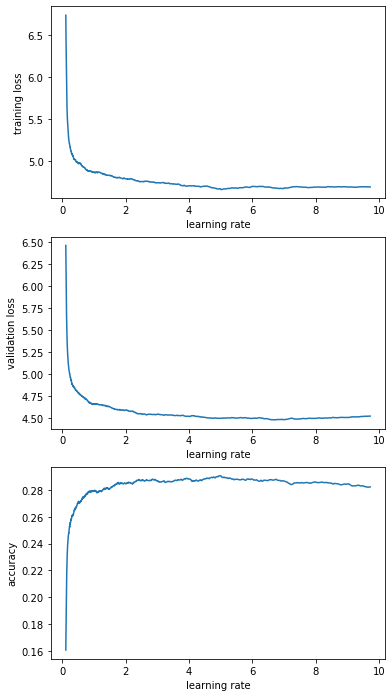

In [25]:
learn.lr_find2(start_lr=1e-1,end_lr=10, num_it=1000)
learn.sched.plot()

In [26]:
lr= 5
# lrs = lr

In [27]:
learn.clip=0.12

In [28]:
wd = 1e-7
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(10,33,0.95,0.85), best_save_name='lm1_wgts')

epoch      trn_loss   val_loss   accuracy   
    0      4.249325   3.981685   0.360129  
    1      3.924953   3.687003   0.3942    
    2      3.739311   3.52452    0.415525  
    3      3.577803   3.410253   0.430687  
    4      3.450777   3.325621   0.442375  
    5      3.366713   3.25247    0.453048  
    6      3.26574    3.191544   0.462357  
    7      3.211711   3.166459   0.466777  
    8      3.142669   3.151656   0.469264  
    9      3.166511   3.144577   0.470708  


[array([3.14458]), 0.4707079687448881]

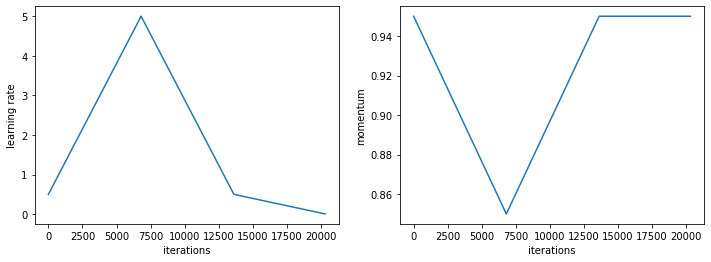

In [29]:
learn.sched.plot_lr()
learn.load('lm1_wgts')
learn.save_encoder('lm1_enc')

## Dataframe for Classification

In [30]:
df_trn = pd.read_csv(DATA_PATH/'train.csv', header=None)
df_val = pd.read_csv(DATA_PATH/'validation.csv', header=None)
df_tst = pd.read_csv(DATA_PATH/'test.csv', header=None)
df_gen = pd.read_csv(DATA_PATH/'general.csv', header=None)

In [31]:
tweets_trn = np.concatenate([df_trn.values, df_val.values, df_gen.values]) #df_gen[df_gen[0]==2].values, df_gen[df_gen[0]==3].values]) #, df_gen.values])
tweets_tst = np.concatenate([df_tst.values])
del df_trn, df_val, df_tst, df_gen

tweets_trn[:5]

array([[1,
        'Sin ser fan de Juan Gabriel, siempre supe que era una fuerza de la naturaleza. Hoy escuché "Querida", y me dio una ternura enorme.'],
       [2,
        'ayer preguntaban y dónde están las solteras!!!! todo mi grupo alza la mano y yo la única que no y todas voltean a verme AJAJAJAJAJJA'],
       [2,
        'Que el finde sea para hacer cualquier cosa que a uno lo haga FELIZ, lo que sea pero que sea lo que a uno le de la reverenda gana'],
       [2,
        'Elige amar, así duela, así parezca un imposible, así te tiemble el alma, así tengas miedo, así vayas a salir herida. El amor transforma'],
       [0,
        'Hoy me sentí como grace de "al fondo hay sitio" cuando la atropellaron, solo que no fue de mentira y casi no la cuento que horrible']],
      dtype=object)

In [32]:
np.random.shuffle(tweets_trn)
tweets_trn[:5]

array([[0, 'No se con qué rayos pintan la señaletica de las pistas, pero mi cuarto apesta a esa huevada'],
       [3,
        'He publicado 3 fotos en Facebook en el álbum "R.C.D Mallorca - F.C. Barcelona 2012". http://t.co/MYFHWBIf'],
       [0,
        'RT “@juliomuley: La Fiscalía descarta por el momento pedir el ingreso en prisión de #Matas. Creen que no existe riego de fuga”'],
       [2, 'De Moputo a Johannsburgo fumigación (no con DDT) antes de despegar. Riesgos zero con malaria.'],
       [0,
        'El cáncer de la corrupción y su consentimiento social   está más extendido aún de lo que pensábamos. Regeneración.']],
      dtype=object)

In [33]:
tweets_trn[:,1] = preprocess_tweets(tweets_trn[:,1])
tweets_tst[:,1] = preprocess_tweets(tweets_tst[:,1])

In [10]:
# NEGA_train_docs = [tweets_trn[i] for i in range(len(tweets_trn)) if tweets_trn[i, 0] == 0]
# POSI_train_docs = [tweets_trn[i] for i in range(len(tweets_trn)) if tweets_trn[i, 0] == 1]
# NEUT_train_docs = [tweets_trn[i] for i in range(len(tweets_trn)) if tweets_trn[i, 0] == 2]
# NONE_train_docs = [tweets_trn[i] for i in range(len(tweets_trn)) if tweets_trn[i, 0] == 3]
# del tweets_trn

# level_train_docs = [NEGA_train_docs,POSI_train_docs,NEUT_train_docs,NONE_train_docs]

# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(NEGA_train_docs),
#                  len(POSI_train_docs),
#                  len(NEUT_train_docs),
#                  len(NONE_train_docs)))

# minSentLvl = min(len(POSI_train_docs),len(NEGA_train_docs),len(NEUT_train_docs),len(NONE_train_docs))

# print('Maximum number of sentences per level : ', minSentLvl)

In [12]:
# import random

# tweets_bal = []
# for i in range(len(level_train_docs)):
#     level_per = np.array(random.sample(level_train_docs[i],minSentLvl))
#     tweets_bal.append(level_per[:minSentLvl])
    
# print("New size of sentences:\n")
# fmt = """Negative Sentences = {:d}
#        \rPositive Sentences = {:d}
#        \rNeutral  Sentences = {:d}
#        \rNone Values        = {:d}"""

# print(fmt.format(len(tweets_bal[0]),
#                  len(tweets_bal[1]),
#                  len(tweets_bal[2]),
#                  len(tweets_bal[3])))

# flat_tweets_bal = [item for sublist in tweets_bal for item in sublist]
# shuf_tweets_bal = random.sample(flat_tweets_bal,len(flat_tweets_bal))

# assert (len(shuf_tweets_bal) == 4 * minSentLvl)
# print("shuf_tweets_bal size = ", len(shuf_tweets_bal))

# tweets_trn = np.array(shuf_tweets_bal)
# print(tweets_trn[:5])

In [34]:
tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(tweets_trn[:,1], tweets_trn[:,0], stratify=tweets_trn[:,0], test_size=0.10)

del tweets_trn
# tweets_train, tweets_valid, labels_train, labels_valid = train_test_split(
#                                                     shuf_tweets_bal[:,1], shuf_tweets_bal[:,0],
#                                                     stratify=shuf_tweets_bal[:,0], 
#                                                     test_size=0.10)

print('train shapes:', tweets_train.shape, labels_train.shape)
print('valid shapes:', tweets_valid.shape, labels_valid.shape)
print('test shapes:', tweets_tst.shape)

train shapes: (7846,) (7846,)
valid shapes: (872,) (872,)
test shapes: (1428, 2)


In [35]:
col_names = ['label', 'tweet']

df_trn = pd.DataFrame({'tweet':tweets_train, 'label':labels_train}, columns=col_names)
df_val = pd.DataFrame({'tweet':tweets_valid, 'label':labels_valid}, columns=col_names)
df_tst = pd.DataFrame({'tweet':tweets_tst[:,1], 'label':tweets_tst[:,0]}, columns=col_names)

del tweets_train, tweets_valid, labels_train, labels_valid, tweets_tst

In [36]:
print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

1    2889
0    2277
3    1873
2     807
Name: label, dtype: int64
1    321
0    253
3    208
2     90
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [37]:
def balance_df(df):
    lst = [df]
    max_size = df['label'].value_counts().max()
    for class_index, group in df.groupby('label'):
        lst.append(group.sample(max_size-len(group), replace=True))
    df = pd.concat(lst)
    return df

df_trn = balance_df(df_trn)
# df_val = balance_df(df_val)

print(df_trn['label'].value_counts())
print(df_val['label'].value_counts())
print(df_tst['label'].value_counts())

3    2889
2    2889
1    2889
0    2889
Name: label, dtype: int64
1    321
0    253
3    208
2     90
Name: label, dtype: int64
Series([], Name: label, dtype: int64)


In [38]:
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'validation.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)
df_trn.shape, df_val.shape

del df_trn, df_val, df_tst

## Classifier tokens

In [80]:
chunksize=24000

re1 = re.compile(r'  +')

In [81]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'validation.csv', header=None, chunksize=chunksize)
df_tst = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [82]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)
tok_tst, tst_labels = get_all(df_tst, 1)

In [83]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

In [43]:
np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)
np.save(CLAS_PATH/'tmp'/'tok_tst.npy', tok_tst)

In [84]:
np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', tst_labels)

# df = pd.read_csv(CLAS_PATH/'test_labels.csv')
# df['label']=df['label'].replace(['N','P','NEU','NONE'],[0,1,2,3])
# np.save(CLAS_PATH/'tmp'/'tst_labels.npy', df['label'].values)

In [45]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
tok_tst = np.load(CLAS_PATH/'tmp'/'tok_tst.npy')

In [46]:
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

52275

In [47]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
tst_clas = np.array([[stoi[o] for o in p] for p in tok_tst])

In [48]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)
np.save(CLAS_PATH/'tmp'/'tst_ids.npy', tst_clas)

## Classifier Model

In [49]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')
itos = pickle.load((TWEETSLM_PATH/'tmp'/'itos.pkl').open('rb'))

In [50]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [51]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
bs = 64

In [52]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1
print(c)

4


In the classifier, unlike LM, we need to read a tweet at a time. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie tweets, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [53]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(TWEETSLM_PATH, trn_dl, val_dl, test_dl=val_dl)

In [54]:
#dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.8
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [55]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[dps[4], 0.1], dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [56]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [57]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.12
learn.metrics = [accuracy]

In [58]:
learn.load_encoder('lm1_enc')

In [59]:
learn.get_layer_groups()

[(Embedding(52275, 400, padding_idx=1), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(400, 1150, dropout=0.3)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 1150, dropout=0.3)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 400, dropout=0.3)
  ), LockedDropout(
  )), PoolingLinearClassifier(
   (layers): ModuleList(
     (0): LinearBlock(
       (lin): Linear(in_features=1200, out_features=50, bias=True)
       (drop): Dropout(p=0.4)
       (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
     )
     (1): LinearBlock(
       (lin): Linear(in_features=50, out_features=4, bias=True)
       (drop): Dropout(p=0.1)
       (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
     )
   )
 )]

In [60]:
learn.freeze_to(-1)

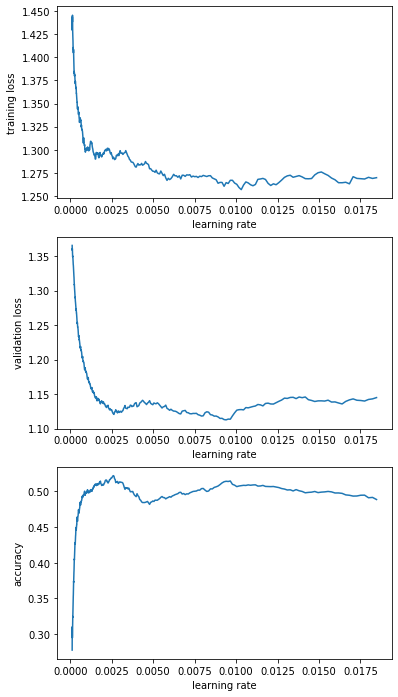

In [61]:
learn.lr_find2(start_lr=1e-4,end_lr=2e-2, num_it=400)
learn.sched.plot()

In [62]:
lr= 2.5e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
print(lrs)
wd = 1e-7

[0.00005 0.00014 0.00037 0.00096 0.0025 ]


In [63]:
# wd = 1e-7
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7), best_save_name='clas2_0')

epoch      trn_loss   val_loss   accuracy   
    0      1.261231   1.073001   0.547445  
    1      1.22829    1.073156   0.509935  
    2      1.234318   1.074202   0.522424  
    3      1.211149   1.06638    0.536244  
    4      1.21646    1.075984   0.541586  


[array([1.07598]), 0.541585726915179]

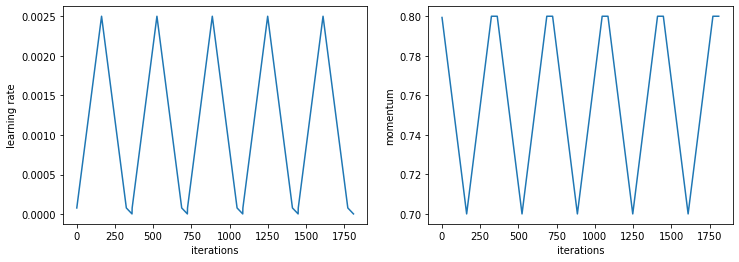

In [64]:
learn.sched.plot_lr()

In [65]:
# learn.save('clas2_0')
learn.load('clas2_0')

In [66]:
learn.freeze_to(-2)

In [67]:
learn.fit(lrs, 5, wds=wd, cycle_len=1, use_clr_beta=(32,10,0.8,0.7),  best_save_name='clas2_1')

epoch      trn_loss   val_loss   accuracy   
    0      1.20285    1.059651   0.551869  
    1      1.180612   1.059029   0.536307  
    2      1.146469   1.044968   0.545112  
    3      1.136172   1.021504   0.571717  
    4      1.126565   1.02185    0.573332  


[array([1.02185]), 0.5733319251118479]

In [68]:
# learn.save('clas2_1')
learn.load('clas2_1')

In [69]:
learn.unfreeze()

In [70]:
learn.fit(lrs, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final_01')

epoch      trn_loss   val_loss   accuracy   
    0      1.090121   0.997699   0.584766  
    1      1.054994   1.009973   0.572709  
    2      1.011024   1.010551   0.589992  
    3      0.939189   1.030442   0.589147  
    4      0.875132   1.032025   0.586339  


[array([1.03203]), 0.5863386821505185]

In [71]:
learn.load('final_01')

In [72]:
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final_02')

epoch      trn_loss   val_loss   accuracy   
    0      0.936849   0.987418   0.603452  
    1      0.938454   1.036082   0.596495  
    2      0.890428   0.998978   0.59603   
    3      0.678662   1.121948   0.594595  
    4      0.553096   1.112516   0.611729  


[array([1.11252]), 0.6117293071505185]

In [73]:
learn.load('final_02')

In [74]:
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final_03')

epoch      trn_loss   val_loss   accuracy   
    0      0.551065   1.237092   0.619204  
    1      0.597439   1.183312   0.609861  
    2      0.58124    1.275583   0.614221  
    3      0.465554   1.383524   0.590097  
    4      0.349803   1.390518   0.602048  


[array([1.39052]), 0.6020481413280642]

In [75]:
learn.load('final_03')

In [76]:
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(32,10,0.8,0.7), best_save_name='final_04')

epoch      trn_loss   val_loss   accuracy   
    0      0.484748   1.219565   0.610853  
    1      0.55784    1.272581   0.598543  
    2      0.568926   1.310115   0.62008   
    3      0.412544   1.420022   0.606282  
    4      0.327975   1.459024   0.606672  


[array([1.45902]), 0.606672297861125]

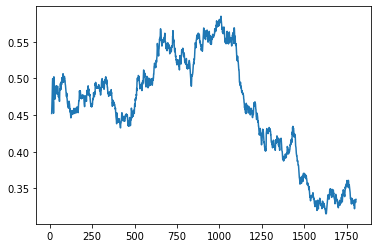

In [77]:
# learn.save('final')
learn.load('final_04')
learn.sched.plot_loss()

## Model Evaluation

In [78]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [85]:
bs = 256
bptt,em_sz,nh,nl = 70,400,1150,3

tst_sent = np.load(CLAS_PATH/'tmp/tst_ids.npy')
tst_lbls = np.load(CLAS_PATH/'tmp/tst_labels.npy').flatten()
# tst_lbls -= tst_lbls.min()
c=4 #int(tst_lbls.max())+1
tst_ds = TextDataset(tst_sent, tst_lbls)
tst_samp = SortSampler(tst_sent, key=lambda x: len(tst_sent[x]))
tst_lbls_sampled = tst_lbls[list(tst_samp)]
tst_dl = DataLoader(tst_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=tst_samp)
md = ModelData(TWEETSLM_PATH, None, tst_dl)
itos = pickle.load(open(TWEETSLM_PATH/'tmp/itos.pkl', 'rb'))
vs = len(itos)

F1(macro) =  0.0
Accuracy  =  0.0


/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dpalominop/anaconda3/envs/fastai_v07/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


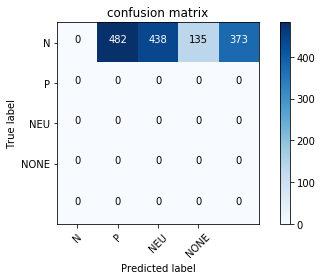

In [101]:
    
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1, layers=[em_sz*3, 50, c], drops=[0., 0.])

learn2 = RNN_Learner(md, TextModel(to_gpu(m)))
learn2.load_encoder('lm1_enc')
learn2.load('final_04')
predictions = np.argmax(learn2.predict(), axis=1)

f1 = f1_score(tst_lbls_sampled, predictions, average='macro')
print('F1(macro) = ', f1)

acc = (tst_lbls_sampled == predictions).mean()
print('Accuracy  = ', acc)


cnf_matrix = confusion_matrix(tst_lbls_sampled, predictions)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'P', 'NEU', 'NONE'], title='confusion matrix')
plt.show()

In [96]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [97]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle, out):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open(out,"w") 
    print(file)
    print(len(predictions))
    for i,tweet in enumerate(root.iter('tweet')): 
        val = getLabel(predictions[list(tst_samp).index(i)])
        ID = tweet.find('tweetid').text
        #print(ID)
        file.write(ID + "\t" + val + "\n")
    file.close() 

In [98]:
# DATA_PATH = Path('D:/Maestria/NLP/AdvacedSentimentAnalysis/database/')
putTestValue(DATA_PATH/"task1-Test.xml", DATA_PATH/"output_ulmfit_2019.txt")

<_io.TextIOWrapper name='DATA/2018/output_ulmfit_2019.txt' mode='w' encoding='UTF-8'>
1428


In [99]:
print(DATA_PATH/"output_ulmfit_2019.txt")

DATA/2018/output_ulmfit_2019.txt
